In [1]:
# import modules
import pandas as pd
import numpy as np
import torch
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os

2023-05-12 09:14:25.191006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:14:26.546494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546568: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-05-12 09:14:26.546576: W 

In [2]:
# evaluation functions
def masked_aCC(pred, label, mask):
    # multi-output average correlation coefficient with masking
    d_label = (label - np.nansum(label,1)/np.sum(mask, 1))
    d_pred = (pred - np.nansum(pred,1)/np.sum(mask, 1))
    x = np.nansum(np.multiply(d_label,d_pred), 1)
    y = np.sqrt(np.multiply(np.nansum(np.square(d_label), 1) , np.nansum(np.square(d_pred), 1)))
    #aCC = np.mean(x/y)
    return x/y
def masked_mse(pred, label, mask):
    # multi-output mse with masking
    return np.nansum(np.array(pred-label)**2, 1)/np.sum(np.array(mask),1)

def one_hot(vector, n):
    out = np.zeros(n)
    for i in vector:
        out[i] = 1
    return out

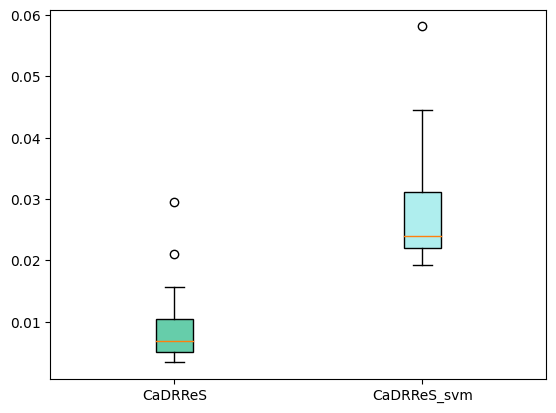

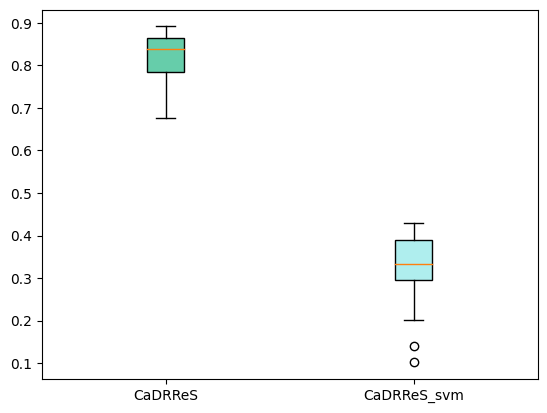

/tmp/ipykernel_262291/3239863066.py:4: RuntimeWarning: invalid value encountered in divide
  d_label = (label - np.nansum(label,1)/np.sum(mask, 1))
/tmp/ipykernel_262291/3239863066.py:5: RuntimeWarning: divide by zero encountered in divide
  d_pred = (pred - np.nansum(pred,1)/np.sum(mask, 1))
/tmp/ipykernel_262291/3239863066.py:7: RuntimeWarning: invalid value encountered in multiply
  y = np.sqrt(np.multiply(np.nansum(np.square(d_label), 1) , np.nansum(np.square(d_pred), 1)))
/tmp/ipykernel_262291/3239863066.py:9: RuntimeWarning: invalid value encountered in divide
  return x/y
/tmp/ipykernel_262291/3239863066.py:12: RuntimeWarning: invalid value encountered in divide
  return np.nansum(np.array(pred-label)**2, 1)/np.sum(np.array(mask),1)


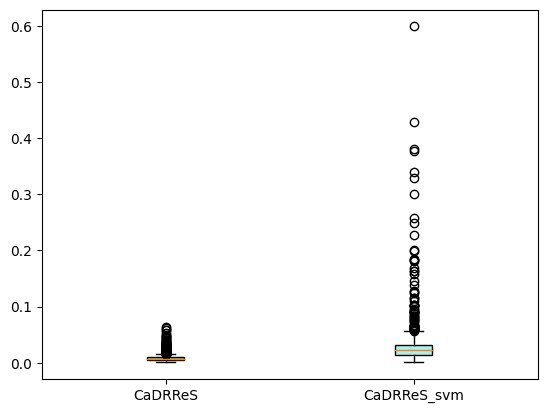

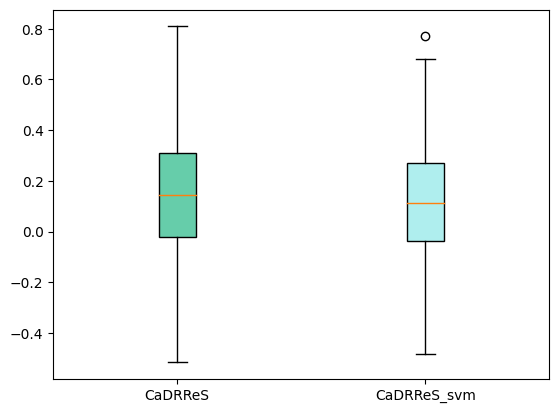

In [75]:
#2-1. evaluation of combined model (cadrres vs. cadrres + svm_rdkfp) on cell-blind set

datadir = "/Users/yihyun/Code/"
## import prediction and ground truth
prism_test_cl = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_test_scdrug.csv"), index_col='smiles')
cadrres_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_1.CaDRReS_CLsim/prediction/CaDRReS_CLsim_cellblind_pred.csv"), index_col='smiles')
### CaDRReS_SVM_LOO_cellblind_pred: leave-one-out prediction of cell-blind set based on the prediction from CaDRReS by SVM
cadrres_svm_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_LOO_cellblind_pred.csv"), index_col=0)

## cell-wise
mask = np.matrix(np.isnan(prism_test_cl)==False, dtype=int).T
label = np.matrix(prism_test_cl).T
pred_cadrres = np.matrix(cadrres_pred).T
pred_cadrres_svm = np.matrix(cadrres_svm_pred).T

## evaluation
### pcc
cadrres_pcc = masked_aCC(pred_cadrres, label, mask)
cadrres_pcc = [pcc for pcc in cadrres_pcc if np.isnan(pcc) == False]
cadrres_svm_pcc = masked_aCC(pred_cadrres_svm, label, mask)
cadrres_svm_pcc = [pcc for pcc in cadrres_svm_pcc if np.isnan(pcc) == False]
cadrres_mse = masked_mse(pred_cadrres, label, mask)
### mse
cadrres_mse = [mse for mse in cadrres_mse if np.isnan(mse) == False]
cadrres_svm_mse = masked_mse(pred_cadrres_svm, label, mask)
cadrres_svm_mse = [mse for mse in cadrres_svm_mse if np.isnan(mse) == False]

## visualization
colors_dict = {'CaDRReS':"mediumaquamarine", 'CaDRReS_svm':"paleturquoise"}
### cell-wise_mse
pred_dict = {'CaDRReS': np.array(cadrres_mse).flatten(),
             'CaDRReS_svm': np.array(cadrres_svm_mse).flatten()}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 

colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### cell-wise_pcc
pred_dict = {'CaDRReS': np.array(cadrres_pcc).flatten(),
            'CaDRReS_svm': np.array(cadrres_svm_pcc).flatten()}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()


## drug-wise
mask = np.matrix(np.isnan(prism_test_cl)==False, dtype=int)
label = np.matrix(prism_test_cl)
pred_cadrres = np.matrix(cadrres_pred)
pred_cadrres_svm = np.matrix(cadrres_svm_pred)

## evaluation
### pcc
cadrres_pcc = masked_aCC(pred_cadrres, label, mask)
cadrres_pcc = [pcc for pcc in cadrres_pcc if np.isnan(pcc) == False]
cadrres_svm_pcc = masked_aCC(pred_cadrres_svm, label, mask)
cadrres_svm_pcc = [pcc for pcc in cadrres_svm_pcc if np.isnan(pcc) == False]
### mse
cadrres_mse = masked_mse(pred_cadrres, label, mask)
cadrres_mse = [mse for mse in cadrres_mse if np.isnan(mse) == False]
cadrres_svm_mse = masked_mse(pred_cadrres_svm, label, mask)
cadrres_svm_mse = [mse for mse in cadrres_svm_mse if np.isnan(mse) == False]

## visualization
### drug-wise_mse
pred_dict = {'CaDRReS': np.array(cadrres_mse).flatten(),
        'CaDRReS_svm': np.array(cadrres_svm_mse).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### drug-wise_pcc
pred_dict = {'CaDRReS': np.array(cadrres_pcc).flatten(),
        'CaDRReS_svm': np.array(cadrres_svm_pcc).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

0.8137519693145929
0.3762321303498786
0.41765376337887883
0.8328853542951209
0.3885064701468515
0.44451456817520274


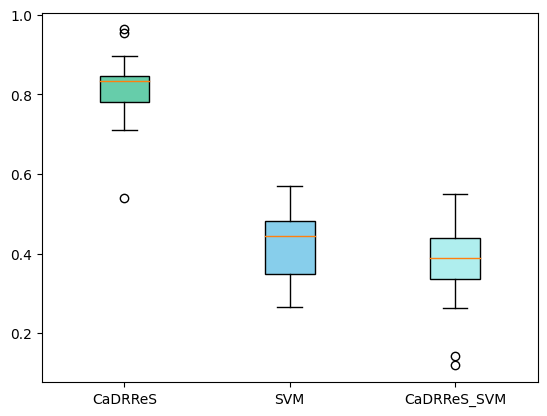

0.008355362536669492
0.026519585904220728
0.02107943567508852
0.00703418749763127
0.02311823569120891
0.020761234113700767


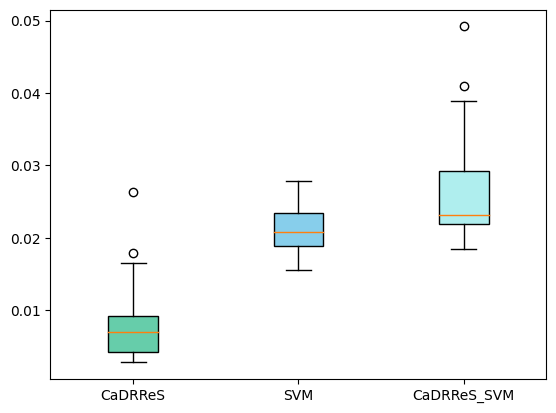

0.1564988151463663
0.14158120116653192
0.2502158708671981
0.15359724829999105
0.1311517921147339
0.2514461219306577


/tmp/ipykernel_1137772/3239863066.py:9: RuntimeWarning: invalid value encountered in divide
  return x/y


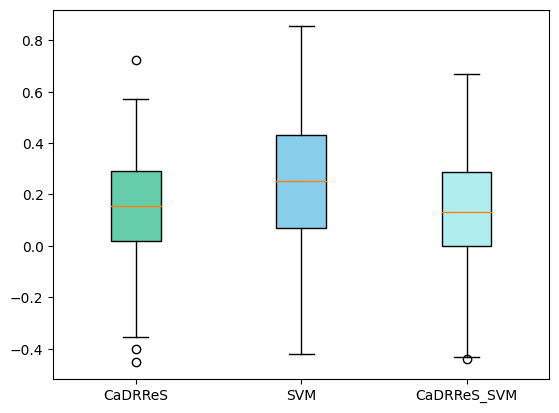

0.008589059362952348
0.027206753855731288
0.021702223824522828
0.006643557387947939
0.021447824768421463
0.012738231197925045


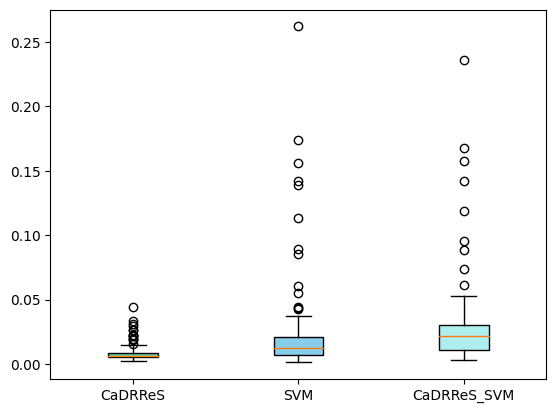

In [4]:
#2-2. evaluation of combined model on disjoint test set
import pandas as pd
prism_both = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_test_molGNN_scdrug.csv"), index_col='smiles')
cadrres_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_1.CaDRReS_CLsim/prediction/CaDRReS_CLsim_disjoint_pred.csv"), index_col = 0)
cadrres_svm_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_disjoint_pred.csv"), index_col = 0)
svm_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/SVM_disjoint_pred.csv"), index_col = 0)
import numpy as np
pred_cadrres = np.matrix(cadrres_pred)
pred_cadrres_svm = np.matrix(cadrres_svm_pred)
pred_svm = np.matrix(svm_pred)
label = np.matrix(prism_both)
mask = np.matrix(np.isnan(prism_both)==False, dtype=int)

## evaluation
### cell-wise
pcc_cadrres = masked_aCC(pred_cadrres.T, label.T, mask.T)
pcc_cadrres = [p for p in pcc_cadrres if np.isnan(p) == False]
pcc_cadrres_svm = masked_aCC(pred_cadrres_svm.T, label.T, mask.T)
pcc_cadrres_svm = [p for p in pcc_cadrres_svm if np.isnan(p) == False]
pcc_svm = masked_aCC(pred_svm.T, label.T, mask.T)
pcc_svm = [p for p in pcc_svm if np.isnan(p) == False]

mse_cadrres = masked_mse(pred_cadrres.T, label.T, mask.T)
mse_cadrres = [e for e in mse_cadrres if np.isnan(e) == False]
mse_cadrres_svm = masked_mse(pred_cadrres_svm.T, label.T, mask.T)
mse_cadrres_svm = [e for e in mse_cadrres_svm if np.isnan(e) == False]
mse_svm = masked_mse(pred_svm.T, label.T, mask.T)
mse_svm = [e for e in mse_svm if np.isnan(e) == False]

print(np.mean(pcc_cadrres))
print(np.mean(pcc_cadrres_svm))
print(np.mean(pcc_svm))
print(np.median(pcc_cadrres))
print(np.median(pcc_cadrres_svm))
print(np.median(pcc_svm))
colors_dict={"SVM": "skyblue", "CaDRReS": "mediumaquamarine",
             "CaDRReS_SVM":"paleturquoise"}
#### cell-wise_pcc
pred_dict = {'CaDRReS': np.array(pcc_cadrres).flatten(),
            'SVM': np.array(pcc_svm).flatten(),
            'CaDRReS_SVM': np.array(pcc_cadrres_svm).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()
#### cell-wise_mse
print(np.mean(mse_cadrres))
print(np.mean(mse_cadrres_svm))
print(np.mean(mse_svm))
print(np.median(mse_cadrres))
print(np.median(mse_cadrres_svm))
print(np.median(mse_svm))

pred_dict = {'CaDRReS': np.array(mse_cadrres).flatten(),
             'SVM': np.array(mse_svm).flatten(),
            'CaDRReS_SVM': np.array(mse_cadrres_svm).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

### drug-wise
pcc_cadrres = masked_aCC(pred_cadrres, label, mask)
pcc_cadrres = [p for p in pcc_cadrres if np.isnan(p) == False]
pcc_cadrres_svm = masked_aCC(pred_cadrres_svm, label, mask)
pcc_cadrres_svm = [p for p in pcc_cadrres_svm if np.isnan(p) == False]
pcc_svm = masked_aCC(pred_svm, label, mask)
pcc_svm = [p for p in pcc_svm if np.isnan(p) == False]

mse_cadrres = masked_mse(pred_cadrres, label, mask)
mse_cadrres = [e for e in mse_cadrres if np.isnan(e) == False]
mse_cadrres_svm = masked_mse(pred_cadrres_svm, label, mask)
mse_cadrres_svm = [e for e in mse_cadrres_svm if np.isnan(e) == False]
mse_svm = masked_mse(pred_svm, label, mask)
mse_svm = [e for e in mse_svm if np.isnan(e) == False]

print(np.mean(pcc_cadrres))
print(np.mean(pcc_cadrres_svm))
print(np.mean(pcc_svm))
print(np.median(pcc_cadrres))
print(np.median(pcc_cadrres_svm))
print(np.median(pcc_svm))
#### drug-wise_pcc
pred_dict = {'CaDRReS': np.array(pcc_cadrres).flatten(),
            'SVM': np.array(pcc_svm).flatten(),
            'CaDRReS_SVM': np.array(pcc_cadrres_svm).flatten(),
            }
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

#### drug-wise_mse
print(np.mean(mse_cadrres))
print(np.mean(mse_cadrres_svm))
print(np.mean(mse_svm))
print(np.median(mse_cadrres))
print(np.median(mse_cadrres_svm))
print(np.median(mse_svm))

pred_dict = {'CaDRReS': np.array(mse_cadrres).flatten(),
            'SVM': np.array(mse_svm).flatten(),
            'CaDRReS_SVM': np.array(mse_cadrres_svm).flatten(),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [18]:
#2-3-1. evaluation of combined model on external dataset (regression)
import pandas as pd
import numpy as np
GDSC2_external_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_external_pred.csv"), index_col = 0)
GDSC2_external = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/GDSC2_external_IC50.csv"), index_col = 0)
pred_GDSC = 1-np.matrix(GDSC2_external_pred)
mask_GDSC = np.matrix(GDSC2_external.loc[GDSC2_external_pred.index, GDSC2_external_pred.columns].isna(), dtype=int)
label_GDSC = np.matrix(GDSC2_external.loc[GDSC2_external_pred.index, GDSC2_external_pred.columns])


prism_train = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_train.csv"), index_col = 'smiles')
prism_both = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_test_molGNN_scdrug.csv"), index_col='smiles')
cadrres_svm_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_disjoint_pred.csv"), index_col = 0)
pred_cadrres_svm = np.matrix(cadrres_svm_pred)
label_prism = np.matrix(prism_both)
mask_prism = np.matrix(np.isnan(prism_both)==False, dtype=int)

# cell-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for cell_line in GDSC2_external_pred.columns:
    tmp_data = GDSC2_external.loc[GDSC2_external_pred.index, cell_line].dropna()
    tmp_result = GDSC2_external_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)
GDSC_scc_result = [scc for scc in GDSC_scc_result if np.isnan(scc)==False]

# evaluation result
PRISM_scc_result = []
for cell_line in cadrres_svm_pred.columns:
    tmp_data = prism_both.loc[cadrres_svm_pred.index, cell_line].dropna()
    tmp_result = cadrres_svm_pred.loc[tmp_data.index, cell_line]

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    PRISM_scc_result.append(scc)
PRISM_scc_result = [scc for scc in PRISM_scc_result if np.isnan(scc)==False]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


0.26059391749119293
0.16570619623203497
0.2734247821300085
0.404844239054006
0.09068951484147661
0.847639337545927


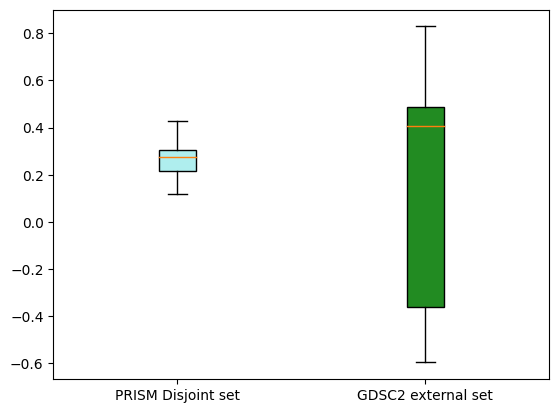

In [19]:
# cell-wise SCC
print(np.mean(np.array(PRISM_scc_result)))
print(np.mean(np.array(GDSC_scc_result)))
print(np.median(np.array(PRISM_scc_result)))
print(np.median(np.array(GDSC_scc_result)))
print(np.percentile(np.array(PRISM_scc_result),75)- np.percentile(np.array(PRISM_scc_result),25))
print(np.percentile(np.array(GDSC_scc_result), 75) - np.percentile(np.array(GDSC_scc_result), 25))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(PRISM_scc_result),
            'GDSC2 external set': np.array(GDSC_scc_result),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [20]:
# drug-wise SCC
from scipy.stats import spearmanr
# evaluation result
GDSC_scc_result = []
for smiles in GDSC2_external_pred.index:
    tmp_data = GDSC2_external.loc[smiles, GDSC2_external_pred.columns].dropna()
    tmp_result = GDSC2_external_pred.loc[smiles, tmp_data.index]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), 1-np.array(tmp_result))
    GDSC_scc_result.append(scc)
GDSC_scc_result = [scc for scc in GDSC_scc_result if np.isnan(scc)==False]
# evaluation result
PRISM_scc_result = []
for smiles in cadrres_svm_pred.index:
    tmp_data = prism_both.loc[smiles, cadrres_svm_pred.columns].dropna()
    tmp_result = cadrres_svm_pred.loc[smiles, tmp_data.index]

    # ranking
    #label_rank = np.array(tmp_data.rank(axis=0))
    #pred_rank = np.array(tmp_result.rank(axis=0))

    scc, scc_p = spearmanr(np.array(tmp_data), np.array(tmp_result))
    PRISM_scc_result.append(scc)
PRISM_scc_result = [scc for scc in PRISM_scc_result if np.isnan(scc)==False]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4921: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


0.06365383333873742
0.436394188987264
0.08354601919819313
0.5378723171826619
0.31361721399801606
0.2620963106613315


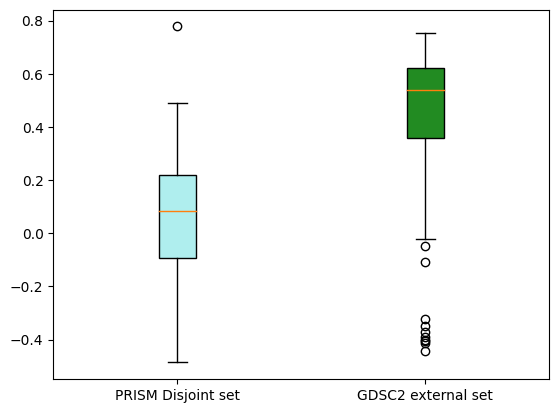

In [21]:
# drug-wise SCC
print(np.mean(np.array(PRISM_scc_result)))
print(np.mean(np.array(GDSC_scc_result)))
print(np.median(np.array(PRISM_scc_result)))
print(np.median(np.array(GDSC_scc_result)))
print(np.percentile(np.array(PRISM_scc_result),75)- np.percentile(np.array(PRISM_scc_result),25))
print(np.percentile(np.array(GDSC_scc_result), 75) - np.percentile(np.array(GDSC_scc_result), 25))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(PRISM_scc_result),
            'GDSC2 external set': np.array(GDSC_scc_result),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [9]:
#2-3-2. evaluation of combined model on external dataset with categories (classification)

from sklearn.metrics import f1_score, accuracy_score, precision_score

## import prediction and ground truth
### PRISM disjoint testing
prism_train = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_train.csv"), index_col = 'smiles')
prism_both = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/prism_test_molGNN_scdrug.csv"), index_col='smiles')
cadrres_svm_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_disjoint_pred.csv"), index_col = 0)

### GDSC2 external testing
from sklearn.metrics import f1_score, accuracy_score, precision_score
GDSC2_external_pred = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/2.Combined_model_evaluation/2_2.CaDRReS_CLsim_SVM/prediction/CaDRReS_SVM_external_pred.csv"), index_col = 0)
GDSC2_external = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/GDSC2_external_auc.csv"), index_col = 0)
GDSC2_external = GDSC2_external[GDSC2_external_pred.columns]


In [ ]:
# drug-wise recall, precision, f1 score
## PRISM disjoint testing
prism_f1 = []
prism_precision = []
prism_recall = []
for mol in prism_both.index:
    cl_data = prism_both.loc[mol].dropna().values
    cl_pred = cadrres_svm_pred.loc[mol][prism_both.loc[mol].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    prism_f1.append(f1_score(gt, pred, average='micro'))
    prism_precision.append(precision_score(gt, pred, average='micro'))
    prism_recall.append(accuracy_score(gt, pred))


GDSC_f1 = []
GDSC_precision = []
GDSC_recall = []
for mol in GDSC2_external_pred.index:
    cl_data = 1-(GDSC2_external.loc[mol].dropna().values)
    cl_pred = GDSC2_external_pred.loc[mol][GDSC2_external.loc[mol].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    GDSC_f1.append(f1_score(gt, pred, average='micro'))
    GDSC_precision.append(precision_score(gt, pred, average='micro'))
    GDSC_recall.append(accuracy_score(gt, pred))

0.6426522082397005
0.3478228756122328
0.6956521739130435
0.3506944444444444


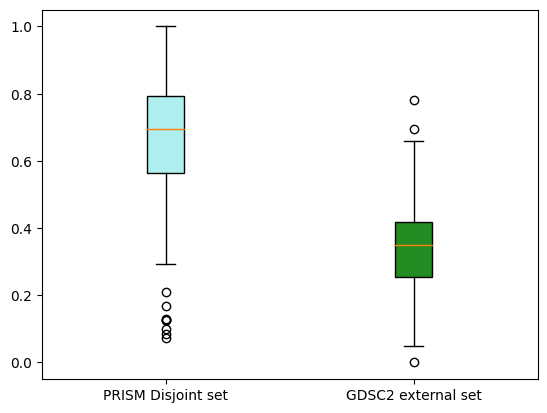

In [11]:
# drug-wise f1 boxplot
print(np.mean(np.array(prism_f1)))
print(np.mean(np.array(GDSC_f1)))
print(np.median(np.array(prism_f1)))
print(np.median(np.array(GDSC_f1)))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(prism_f1),
            'GDSC2 external set': np.array(GDSC_f1),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()

In [12]:
# cell-wise recall, precision, f1 score
## PRISM disjoint testing
prism_f1 = []
prism_precision = []
prism_recall = []
for cell_line in prism_both.columns:
    cl_data = prism_both[cell_line].dropna().values
    cl_pred = cadrres_svm_pred[cell_line][prism_both[cell_line].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    prism_f1.append(f1_score(gt, pred, average='micro'))
    prism_precision.append(precision_score(gt, pred, average='micro'))
    prism_recall.append(accuracy_score(gt, pred))

## GDSC2 external testing (categories)
from sklearn.metrics import f1_score, accuracy_score, precision_score
GDSC2_external = pd.read_csv(os.path.join(datadir, "drug_sensitivity_prediction/0.data/processed/GDSC2_external_auc.csv"), index_col = 0)
GDSC_f1 = []
GDSC_precision = []
GDSC_recall = []
for cell_line in GDSC2_external_pred.columns:
    cl_data = 1-(GDSC2_external[cell_line].dropna().values)
    cl_pred = GDSC2_external_pred[cell_line][GDSC2_external[cell_line].isna() == False].values
    gt = []
    for val in cl_data:
        if val >= 0.6:
            gt.append("potential")
        elif val <= 0.2:
            gt.append("inacitve")
        else:
            gt.append("unclear")
    pred = []
    for val in cl_pred:
        if val >= 0.6:
            pred.append("potential")
        elif val <= 0.2:
            pred.append("inacitve")
        else:
            pred.append("unclear")
    GDSC_f1.append(f1_score(gt, pred, average='micro'))
    GDSC_precision.append(precision_score(gt, pred, average='micro'))
    GDSC_recall.append(accuracy_score(gt, pred))

0.6409253696035946
0.332939856952501
0.7455357142857143
0.22935779816513763


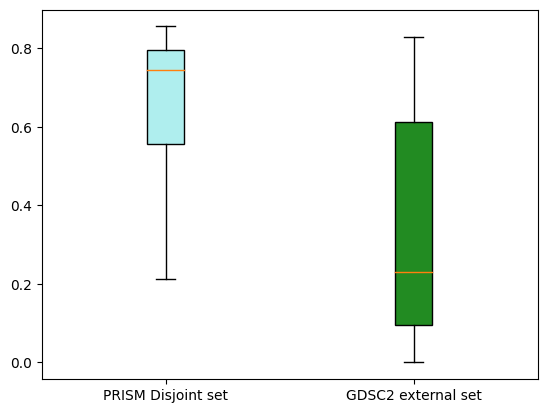

In [14]:
# cell-wise f1 score boxplot
print(np.mean(np.array(prism_f1)))
print(np.mean(np.array(GDSC_f1)))
print(np.median(np.array(prism_f1)))
print(np.median(np.array(GDSC_f1)))
colors_dict={"PRISM Disjoint set": "paleturquoise", "GDSC2 external set": "forestgreen"}

pred_dict = {'PRISM Disjoint set': np.array(prism_f1),
            'GDSC2 external set': np.array(GDSC_f1),}
fig, ax = plt.subplots()
box = ax.boxplot(pred_dict.values(), patch_artist=True)
ax.set_xticklabels(pred_dict.keys())
 
colors=[colors_dict[key] for key in pred_dict.keys()]
 
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
 
plt.show()